In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
import os

from ggplot import *

## Overview
* select 5'UTRs longer than 80 nt
* count reads aligned to these UTRs (pysam)
* plot utr reads -bcm vs utr reads + bcm
* select UTRs with increased number of reads upon addition of BCM (clustering?)
* compare selected UTRs with genes upregulated in the stationary phase as discovered by DESeq2
* compare selected UTRs with small RNA binding sites (pybedtools?)

### Sample table and barcodes

In [3]:
# Sample titles with corresponding barcodes
samples = {
    's9': ['ATCACG', 'ACAGTG'],
    's9+bcm': ['CGATGT', 'GCCAAT'],
    's17': ['TTAGGC', 'GATCAG'],
    's17+bcm': ['TGACCA', 'TAGCTT'],
    's19': ['CAGATC','GGCTAC'],
    's19+bcm': ['ACTTGA', 'CTTGTA']
}

# Barcodes
barcodes = ['ATCACG', 'ACAGTG', 'CGATGT', 'GCCAAT', 'TTAGGC', 'GATCAG', 'TGACCA', 'TAGCTT', 'CAGATC','GGCTAC', 'ACTTGA', 'CTTGTA']

### Load counts for genes, calculate counts in UTRs longer than 80 nt

Gene counts were obtained using `htseq` program against the standard NC_000913 .GFF file The was I calculate reads in UTRs here is not strand-specific. So the numbers can be confounded if there is a transcript going in the opposite direction. We can solve this later if needed.

In [5]:
dfm = pd.DataFrame.from_csv('../data/dfm.csv', sep='\t')
dfm

,TSS,TU_name,coord_3,coord_5,first_gene_3,first_gene_5,gene,operon,promoter,seq_5UTR,...,utr_CGATGT,utr_GCCAAT,utr_TTAGGC,utr_GATCAG,utr_TGACCA,utr_TAGCTT,utr_CAGATC,utr_GGCTAC,utr_ACTTGA,utr_CTTGTA
0,5030,yaaX,5234,5030,5530,5234,yaaX,yaaX,yaaXp4,ATTATCTCAATCAGGCCGGGTTTGCTTTTATGCAGCCCGGCTTTTT...,...,351,370,298,448,439,446,137,235,479,450
1,6587,yaaA,6587,6459,6459,5683,yaaA,yaaA,yaaAp3,ATCCGGATATCGGTCGCCAGCTTTCTCCGGACGCGTGGGATGATGT...,...,163,225,175,315,181,281,206,114,388,305
2,6615,yaaA,6615,6459,6459,5683,yaaA,yaaA,yaaAp5,GTGCGCCCGGTGTTTGATCCATTGCGTTATCCGGATATCGGTCGCC...,...,172,236,175,322,191,303,207,116,411,329
3,11542,yaaW,11542,11356,11356,10643,yaaW,yaaW,yaaWp3,GCCTGAATATTCCTTCAGAAATAAAAGAAGGGCAAACCACTGACTG...,...,504,776,12,36,567,1056,12,24,1505,1546
4,11913,yaaI,11913,11786,11786,11382,yaaI,yaaI,yaaIp3,ATCGCAGCCAAGGCATTCATCAAAAAATTGTAATAAAAAGAAAAGA...,...,304,356,14,23,389,399,8,13,458,440
5,11938,yaaI,11938,11786,11786,11382,yaaI,yaaI,yaaIp2,GCAATTTTATTCATATAAAGAATGAATCGCAGCCAAGGCATTCATC...,...,340,419,14,24,438,510,8,15,565,528
6,12048,dnaK-tpke11-dnaJ,12163,12048,14079,12163,dnaK,dnaK-tpke11-dnaJ,dnaKp1,AACCGCAGTGAGTGAGTCTGCAAAAAAATGAAATTGGGCAGTTGAA...,...,2977,6584,4799,2830,6350,6968,2336,6099,15976,14174
7,17317,nhaAR,17489,17317,18655,17489,nhaA,nhaAR,nhaAp2,GGTCACTCGTGAGCGCTTACAGCCGTCAAAAACGCATCTCACCGCT...,...,792,1358,133,215,1301,1908,74,137,2949,2223
8,21210,rpsT,21210,21078,21078,20815,rpsT,rpsT,rpsTp1,GCCATCACTACGTAACGAGTGCCGGCACATTAACGGCGCTTATTTG...,...,9302,8966,14726,24465,10912,9380,23735,17554,7045,5706
9,21833,ileS-lspA-fkpB-ispH,22391,21833,25207,22391,ileS,ribF-ileS-lspA-fkpB-ispH,ileSp1,GCTGGCATGGAATACGGCTTCGATATCACCAGTACGCAAACTTTTT...,...,1739,2728,5454,5556,2509,3155,4785,5718,6382,5578


### Normalize counts for feature length, log-transform, and take means for replicates

Pseudo-counts (+1) are added during UTR reads counting to make sure we can log-transform the data.

In [6]:
id_vars = ['TSS','TU_name','coord_5','coord_3','gene', 'UTR_length']
value_vars = ['s9','s17','s19','s9+bcm','s17+bcm','s19+bcm']

dfn = dfm.copy()

# Normalize counts by gene and utr length
def norm_orf(barcode, rec):
    return float(rec[barcode] / abs(rec['first_gene_5'] - rec['first_gene_3']))

def norm_utr(barcode, rec):
    return float(rec['utr_{0}'.format(barcode)] / rec['UTR_length'])

for barcode in barcodes:
    dfn['orf_{0}'.format(barcode)] = dfn.apply(lambda rec: norm_orf(barcode, rec), axis=1)
    dfn['utr_{0}'.format(barcode)] = dfn.apply(lambda rec: norm_utr(barcode, rec), axis=1)

    
df = dfn[id_vars].copy()
# Take means across replicates according to the samples dict
for sample, bcs in samples.items():
    df['orf_{0}'.format(sample)] = np.log10(dfn[['orf_{0}'.format(b) for b in list(bcs)]].mean(axis=1))
    df['utr_{0}'.format(sample)] = np.log10(dfn[['utr_{0}'.format(b) for b in list(bcs)]].mean(axis=1))
df

,TSS,TU_name,coord_5,coord_3,gene,UTR_length,orf_s19,utr_s19,orf_s17,utr_s17,orf_s9,utr_s9,orf_s19+bcm,utr_s19+bcm,orf_s17+bcm,utr_s17+bcm,orf_s9+bcm,utr_s9+bcm
0,5030,yaaX,5030,5234,yaaX,204,-0.123962,-0.040117,-0.068171,0.262079,-0.040733,0.278642,0.415199,0.357356,0.237554,0.336283,0.224628,0.247275
1,6587,yaaA,6459,6587,yaaA,128,-0.005917,0.096910,0.068941,0.281956,0.040578,0.236199,0.232518,0.432493,0.048408,0.256402,-0.027730,0.180592
2,6615,yaaA,6459,6615,yaaA,156,-0.005917,0.015048,0.068941,0.202202,0.040578,0.161944,0.232518,0.375077,0.048408,0.199572,-0.027730,0.116506
3,11542,yaaW,11356,11542,yaaW,186,-1.074938,-1.014240,-1.112727,-0.889302,-1.158484,-1.052029,0.825338,0.913899,0.450862,0.639776,0.384203,0.536667
4,11913,yaaI,11786,11913,yaaI,127,-1.226170,-1.082614,-0.993598,-0.836632,-1.101231,-0.913472,0.611366,0.548443,0.369510,0.491693,0.270702,0.414710
5,11938,yaaI,11786,11938,yaaI,152,-1.226170,-1.121146,-0.993598,-0.903090,-1.101231,-0.926571,0.611366,0.555747,0.369510,0.493935,0.270702,0.397368
6,12048,dnaK-tpke11-dnaJ,12048,12163,dnaK,115,1.643435,1.564357,1.360430,1.520740,1.370097,1.332965,1.966770,2.117559,1.639229,1.762711,1.539609,1.618775
7,17317,nhaAR,17317,17489,nhaA,172,-0.051339,-0.212276,-0.026888,0.005021,0.068752,-0.024675,0.958300,1.177100,0.557119,0.969811,0.466310,0.795880
8,21210,rpsT,21078,21210,rpsT,132,2.264445,2.194230,2.231317,2.171582,2.351260,2.320020,1.655317,1.683940,1.954628,1.885721,1.922250,1.840087
9,21833,ileS-lspA-fkpB-ispH,21833,22391,ileS,558,0.949946,0.973649,0.793145,0.994123,0.818969,0.927446,0.933123,1.030067,0.598032,0.705459,0.554431,0.602352


### Plot wild type with vs without BCM

Two clusters are apparent. We are after the UTRs that are upregulated by the addition of BCM (cloud of points in the left part of the plot along y=0 line and in general (significantly) above y=x line).

BTW, the point size is the length of UTR. No (apparent) correlation here.

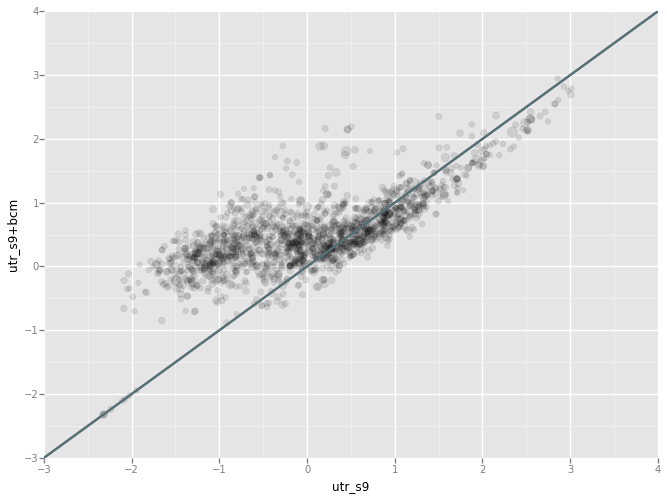

<ggplot: (8764732990085)>


In [8]:
p = ggplot(df, aes(x='utr_s9', y='utr_s9+bcm', size='UTR_length')) \
        + geom_point(alpha=0.1) \
        + geom_abline(slope=1, intercept=0, size=2.5, color='#586e75')
print(p)

### Clustering

Now we need a way to split the points the way we want. Let's try a bunch of clustering algorithms from `scikit-learn.`

/home/ilya/.virtualenvs/pydata/local/lib/python2.7/site-packages/sklearn/neighbors/graph.py:36: DeprecationWarning: The behavior of 'kneighbors_graph' when mode='connectivity' will change in version 0.18. Presently, the nearest neighbor of each sample is the sample itself. Beginning in version 0.18, the default behavior will be to exclude each sample from being its own nearest neighbor. To maintain the current behavior, set include_self=True.
  "behavior, set include_self=True.", DeprecationWarning)


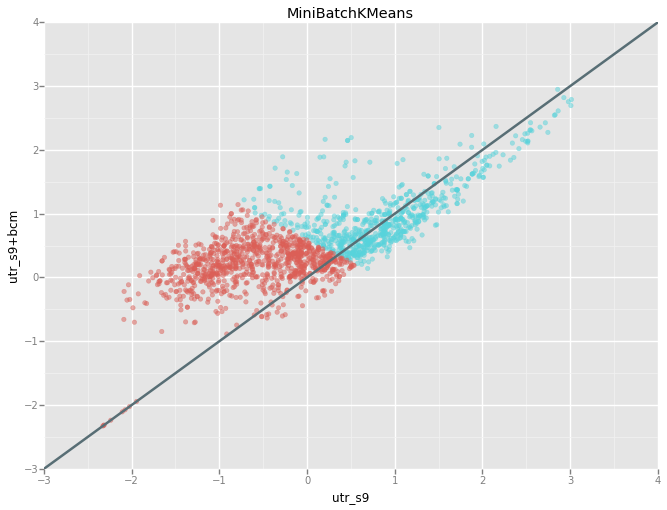

<ggplot: (8764722090949)>


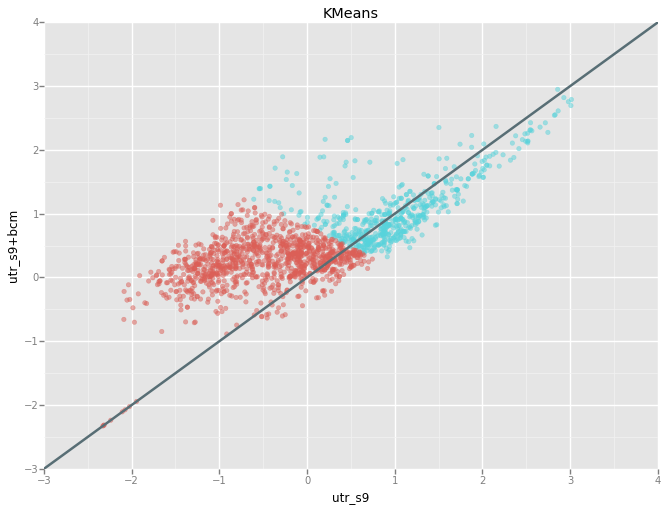

<ggplot: (8764721996045)>


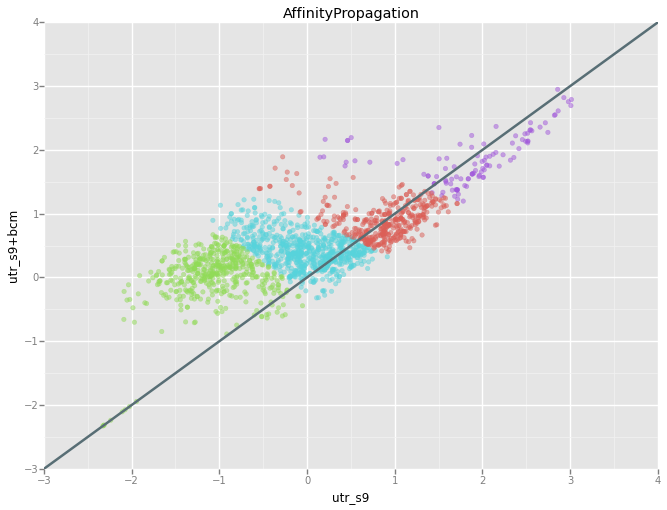

<ggplot: (8764721934057)>


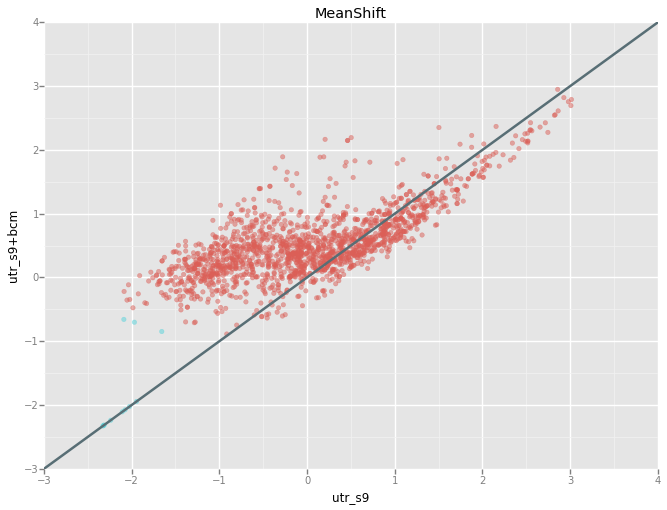

<ggplot: (8764721794421)>


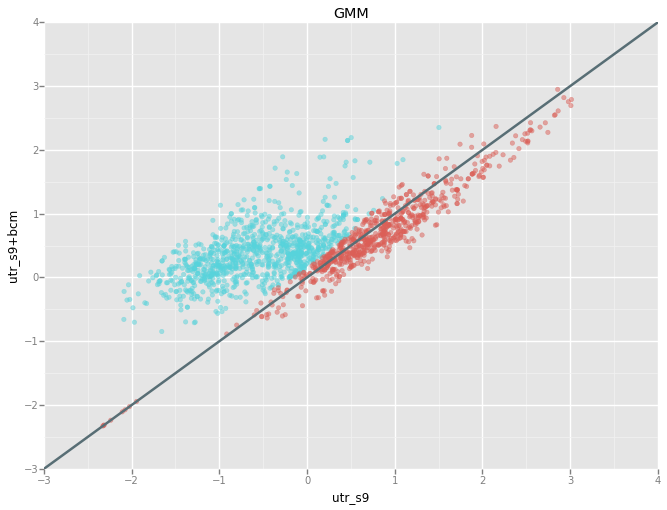

<ggplot: (8764721719985)>


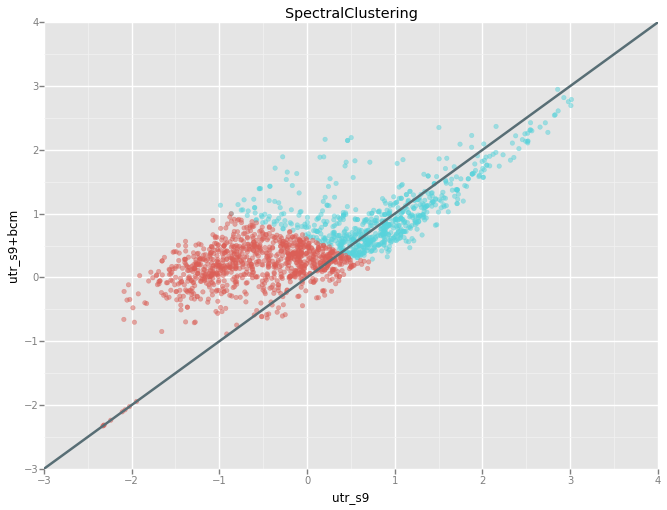

<ggplot: (8764721821677)>


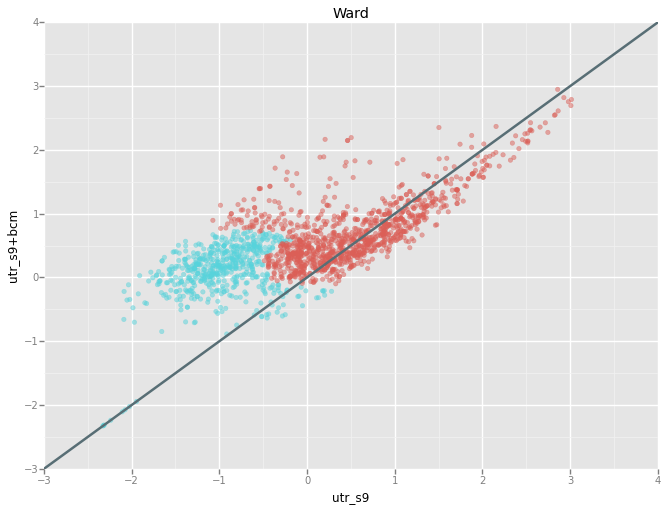

<ggplot: (8764732380341)>


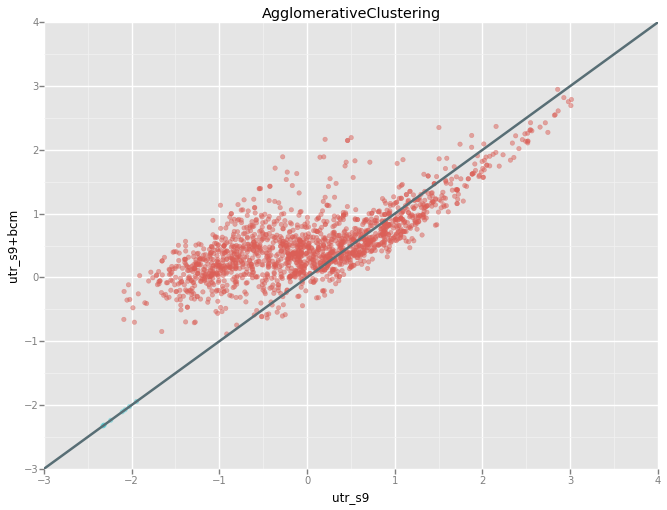

<ggplot: (8764721804557)>


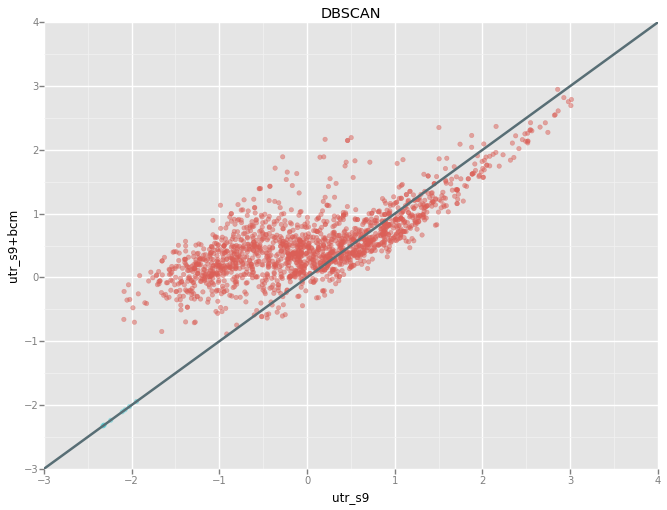

<ggplot: (8764732988737)>


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn import cluster
from sklearn import mixture

X = df.as_matrix(columns=['utr_s9', 'utr_s9+bcm'])
X = StandardScaler().fit_transform(X)

bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)
connectivity = kneighbors_graph(X, n_neighbors=20)
connectivity = 0.05 * (connectivity + connectivity.T)
#distances = euclidean_distances(X)

gmm = mixture.GMM(n_components=2, covariance_type='full')

ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=2, batch_size=200)
kmeans = cluster.KMeans(n_clusters=2)
ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=2, n_neighbors=20, eigen_solver='arpack', affinity='nearest_neighbors')
dbscan = cluster.DBSCAN(eps=.5)
affinity_propagation = cluster.AffinityPropagation(damping=.95, preference=-200)
average_linkage = cluster.AgglomerativeClustering(linkage='average', affinity='cityblock', n_clusters=2, connectivity=connectivity)

for name, alg in [
                    ('MiniBatchKMeans', two_means),
                    ('KMeans', kmeans),
                    ('AffinityPropagation', affinity_propagation),
                    ('MeanShift', ms),
                    ('GMM', gmm),
                    ('SpectralClustering', spectral),
                    ('Ward', ward),
                    ('AgglomerativeClustering', average_linkage),
                    ('DBSCAN', dbscan)
                ]:
    alg.fit(X)
    if hasattr(alg, 'labels_'):
        df['label'] = alg.labels_.astype(np.int)
    else:
        df['label'] = alg.predict(X)
    
    p = ggplot(df, aes(x='utr_s9', y='utr_s9+bcm', color='label')) \
        + geom_point(alpha=0.5) \
        + ggtitle(name) \
        + geom_abline(slope=1, intercept=0, size=2.5, color='#586e75')
    print(p)